In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
# from torch.utils.tensorboard import SummaryWriter

from PIL import Image
from skimage.color import rgba2rgb, hsv2rgb
import cv2
from IPython.display import display, clear_output
from math import *
import time

from os import makedirs, path
from copy import deepcopy

from tqdm import tqdm

from physarumCA import physarumCA, min_max
import pygame

pygame 2.0.1 (SDL 2.0.14, Python 3.9.9)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
# %load_ext autoreload
# %autoreload 2

In [3]:
mass_density = 1e1 # amount of mass per pixel on init

In [4]:
def LMB_make(state, r=5, s=1):
    '''
    left click to make
    r: radius of brush
    s: smoothing / sigma
    '''
    xcl, ycl = pygame.mouse.get_pos()
    xcl, ycl = int(xcl/UPSCALE), int(ycl/UPSCALE)
    
    # radial blur
    xm, ym = torch.meshgrid(torch.linspace(-1, 1, 2*r), torch.linspace(-1, 1, 2*r))
    rm = torch.sqrt(xm**2 + ym**2).type(torch.double)
    blur = torch.exp(-rm**2 / s**2)
    blur = torch.where(rm <= 1., blur, 0.) # circular mask
    
    xslice = range(xcl - r, xcl + r)
    yslice = range(ycl - r, ycl + r)
    for count_i, i in enumerate(xslice):
        for count_j, j in enumerate(yslice):
            i = i % RESX
            j = j % RESY
            state[:, :, i, j] += mass_density / 3.
    return state
    
    
def RMB_del(state, r=5, s=1):
    '''
    right click to erase
    r: radius of eraser
    s: smoothing / sigma
    '''
    xcl, ycl = pygame.mouse.get_pos()
    xcl, ycl = int(xcl/UPSCALE), int(ycl/UPSCALE)
    
    # radial blur
    xm, ym = torch.meshgrid(torch.linspace(-1, 1, 2*r), torch.linspace(-1, 1, 2*r))
    rm = torch.sqrt(xm**2 + ym**2).type(torch.double)
    blur = (1 - torch.exp(-rm**2 / s**2))
    blur = torch.where(rm <= 1., blur, 1.) # circular mask
    
    xslice = range(xcl - r, xcl + r)
    yslice = range(ycl - r, ycl + r)
    for count_i, i in enumerate(xslice):
        for count_j, j in enumerate(yslice):
            i = i % RESX
            j = j % RESY
            state[:, :, i, j] = 0.
    return state

def WHEEL_permute(cdim_order, direction):
    cdim_order = np.mod(np.add(cdim_order, direction), CHANNELS)
    
    return cdim_order
    
def WHEEL_param(param, direction, increment):
    
    return param + direction * increment

# Test

In [5]:
ca = physarumCA().cuda() 

In [6]:
# brush properties
r = 20
s = 1

In [7]:
# resolution of grid
RESX=640
RESY=480

# pygame stuff
######################################
pygame.init()
size = RESX, RESY
# screen = pygame.display.set_mode(size)
screen = pygame.Surface(size)
UPSCALE = 2.5
RESXup, RESYup = int(RESX*UPSCALE), int(RESY*UPSCALE)
upscaled_screen = pygame.display.set_mode([RESXup, RESYup])

running = True
time_ticking = True
self_organize = False
LMB_trigger = False
RMB_trigger = False
WHEEL_trigger = False
HSV_toggle = False

clock = pygame.time.Clock()
font = pygame.font.SysFont("Noto Sans", 12)
def update_fps(clock, font):
    fps = str(int(clock.get_fps()))
    fps_text = font.render(fps, 1, pygame.Color("white"))
    fps_bg = pygame.Surface((fps_text.get_height(),fps_text.get_width()))  # the size of your rect
    fps_bg.set_alpha(50)                # alpha level
    fps_bg.fill((255,255,255))           # this fills the entire surface

    fps_surf = pygame.Surface((fps_bg.get_height(), fps_bg.get_width()))
    fps_surf.blit(fps_bg, (0, 0))
    fps_surf.blit(fps_text, (0, 0))
    return fps_surf

def show_wheel_info(param, name):
    font = pygame.font.SysFont("Noto Sans", 12)
    info_str = f'{name}: {param:.4f}'
    info_txt = font.render(info_str, 1, pygame.Color("white"))
    info_bg = pygame.Surface((info_txt.get_height(),info_txt.get_width()))  # the size of your rect
    info_bg.set_alpha(50)                # alpha level
    info_bg.fill((255,255,255))           # this fills the entire surface

    info_surf = pygame.Surface((info_bg.get_height(), info_bg.get_width()))
    pos = (0., 0.)
    info_surf.blit(info_bg, pos)
    info_surf.blit(info_txt, pos)
    return info_surf
######################################

sparsity = 0.05
device = 'cuda'

def init_state():
    #mass = (torch.rand(1, 1, RESX, RESY, requires_grad=False, device=device) > sparsity) * mass_density + 1e-6     # mass = [kg]
    mass = mass_density * torch.rand(1, 1, RESX, RESY, requires_grad=False, device=device)    # mass = [kg]
    # mass[..., RESX//3:2*RESX//3, RESY//3:2*RESY//3] = mass_density
    trail = torch.zeros_like(mass, device=device)
    #mass[..., RESX//2, RESY//2] = mass_density
    force = torch.zeros(2, 1, RESX, RESY, requires_grad=False, device=device)    # force = [kg * m / s^2]
    # momentum = torch.zeros(2, 1, RESX, RESY, requires_grad=False, device=device) # momentum = [kg * m / s]
    momentum = torch.randn(2, 1, RESX, RESY, requires_grad=False, device=device) 
    
    return mass, trail, force, momentum

mass, trail, force, momentum = init_state()

A = 1.
A_factor = 1.
A_sign = 1

update_rate = 1.
ticker = 0.
sink = False
export_imgs = False
imgs = []

with torch.no_grad():
    while running:              
        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                running = False
                
            if event.type == pygame.MOUSEBUTTONDOWN:
                if event.button == 1:
                    LMB_trigger = True
                if event.button == 3:
                    RMB_trigger = True
            if event.type == pygame.MOUSEBUTTONUP:
                if event.button == 1:
                    LMB_trigger = False
                if event.button == 3:
                    RMB_trigger = False
                    
            if event.type == pygame.MOUSEWHEEL:
                WHEEL_trigger = True
                direction = event.y
                
                
            if event.type == pygame.KEYDOWN and event.key == pygame.K_LEFTBRACKET:
                ca.rule.kpow += -0.05
                ca.rule.kernel = make_kernel(pow=ca.rule.kpow)
            if event.type == pygame.KEYDOWN and event.key == pygame.K_RIGHTBRACKET:
                ca.rule.kpow += 0.05
                ca.rule.kernel = make_kernel(pow=ca.rule.kpow)
            
            if event.type == pygame.KEYDOWN and event.key == pygame.K_k:
                ca.rule.generate_cppn_kernel()
            if event.type == pygame.KEYDOWN and event.key == pygame.K_c:
                ca.rule.generate_cppn()
            if event.type == pygame.KEYDOWN and event.key == pygame.K_h:
                HSV_toggle = not HSV_toggle

            if event.type == pygame.KEYDOWN and event.key == pygame.K_e:
                export_imgs = not export_imgs
            if event.type == pygame.KEYDOWN and event.key == pygame.K_p:
                # pause/toggle time
                time_ticking = not time_ticking
                
            if event.type== pygame.KEYDOWN and event.key == pygame.K_r:
                # reinit
                mass, trail, force, momentum = init_state()
                
                

        mouse_pos = pygame.mouse.get_pos()
        if LMB_trigger:
            mass = LMB_make(mass, r=r, s=s)
        if RMB_trigger:
            mass = RMB_del(mass, r=r, s=s)
        if WHEEL_trigger:
            A_factor = A_sign * 10**WHEEL_param(np.log10(np.abs(A_factor)), A_sign * direction, 1./20.)
            
            if A_factor < 1e-4 and direction == -1:
                A_sign = -1
            if A_factor > -1e-4 and direction == 1:
                A_sign = 1

            WHEEL_trigger = False
        
        #nx = mass.cpu()[0, 0, :, :].numpy() 
        nx = [mass[0, 0, :, :], torch.ones_like(mass[0, 0, :, :]), trail[0, 0, :, :]] 
        # nx = mass[0, 0, :, :]
        # nx = trail[0, 0, :, :]
        # nx = min_max(nx.log1p()).cpu().numpy() 
        nx = torch.stack([min_max(c.log1p()) for c in nx], dim=-1).cpu().numpy() 
        # nx = min_max(torch.stack([min_max(c.log1p()) for c in nx], dim=-1).cpu().numpy())
        if HSV_toggle:
            
            nx = cv2.cvtColor(nx[..., [1, 0, 2]] , cv2.COLOR_HSV2RGB_FULL)
#         nx = hsv2rgb(nx[..., [1, 2, 0]])
        
        # nx = torch.stack([mass.cpu()[0, 0, :, :], momentum.cpu().norm(p=2, dim=0, keepdim=True)[0, 0], force.cpu().norm(p=2, dim=0, keepdim=True)[0, 0]], dim=-1).numpy()
        nx = nx * 255.

        if time_ticking:
            mass, trail, momentum, force = ca.forward(mass, trail, momentum, force, A * A_factor)
            ticker += 1


        if export_imgs and time_ticking:
            imgs.append(nx)


        pygame.surfarray.blit_array(screen, nx)        
        frame = pygame.transform.scale(screen, (RESXup, RESYup))
        upscaled_screen.blit(frame, frame.get_rect())
        upscaled_screen.blit(update_fps(clock, font), (10,0))
        upscaled_screen.blit(show_wheel_info(A_factor, 'A'), (RESXup - 100,15))
            
        pygame.display.flip()
        clock.tick(240)
        
pygame.quit()


In [8]:
self = ca.rule
shape = trail.shape
velocity = torch.where(mass < 1e-8, momentum.new_zeros(()), momentum / mass)
velocity = F.unfold(velocity, 1)

new_force = F.pad(trail, (1, 1, 1, 1), mode='circular')
new_force = F.unfold(new_force, 3)

## take only kernel contributions that align with the velocity
new_force = new_force * (F.unfold(self.kernel, 3) * (velocity * self.directions.transpose(1, 0).unsqueeze(-1) > 0.))
new_force = new_force.view(2,  9, shape[-2], shape[-1]).sum(dim=[0, 1], keepdim=True)

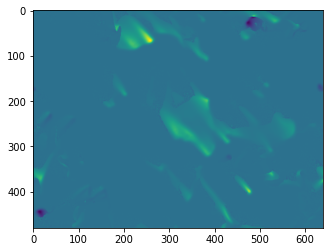

In [9]:
plt.imshow(new_force.cpu().numpy()[0, 0].transpose())

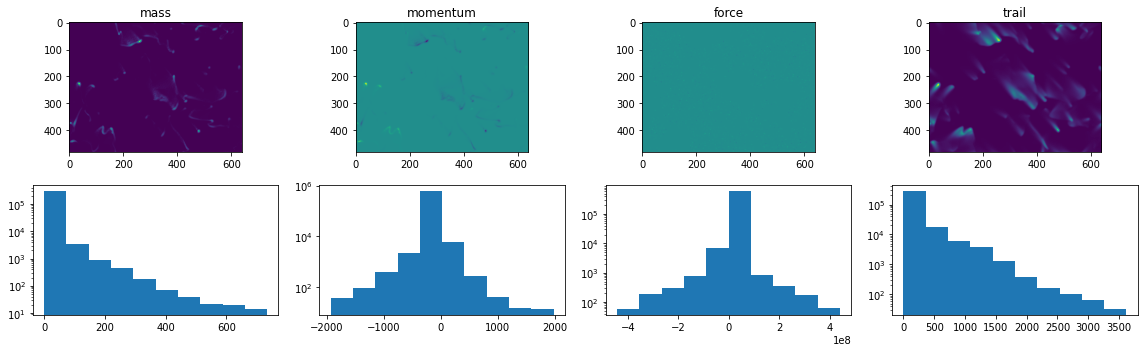

In [10]:
fig, axes = plt.subplots(2, 4, figsize=(16, 5))

axes = axes.flatten()

axes[0].imshow(mass[0, 0].t().cpu().numpy())
axes[0].set_title('mass')
axes[1].imshow(momentum[0, 0].t().cpu().numpy())
axes[1].set_title('momentum')
axes[2].imshow(force[0, 0].t().cpu().numpy())
axes[2].set_title('force')
axes[3].imshow(trail[0, 0].t().cpu().numpy())
axes[3].set_title('trail')

axes[4].hist(mass.reshape(-1).cpu().numpy()); axes[4].set_yscale('log');
axes[5].hist(momentum.reshape(-1).cpu().numpy()); axes[5].set_yscale('log');
axes[6].hist(force.reshape(-1).cpu().numpy()); axes[6].set_yscale('log');
axes[7].hist(trail.reshape(-1).cpu().numpy()); axes[7].set_yscale('log');

plt.tight_layout()

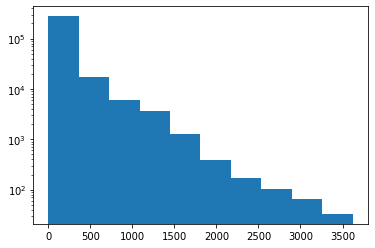

In [11]:
plt.hist(trail.cpu().numpy().reshape(-1)); plt.yscale('log')

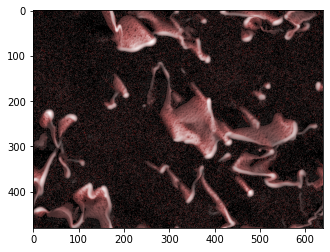

In [12]:
nx = [mass[0, 0, :, :], momentum.norm(p=2, dim=0, keepdim=True)[0, 0], force.norm(p=2, dim=0, keepdim=True)[0, 0]]
nx = torch.stack([min_max(c.log1p()) for c in nx], dim=-1).cpu().numpy()
nx = cv2.cvtColor(nx, cv2.COLOR_HLS2RGB_FULL)
plt.imshow(nx[...].transpose(1, 0, 2))

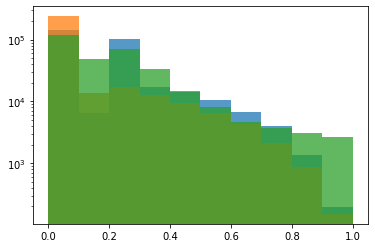

In [13]:
plot_xs = [momentum.norm(p=2, dim=0, keepdim=True)[0, 0],
           mass[0, 0, :, :],
           force.norm(p=2, dim=0, keepdim=True)[0, 0]]

for plot_x in plot_xs:
    plot_x = plot_x.log1p()
    plot_x = min_max(plot_x)

    plt.hist(plot_x.cpu().numpy().reshape(-1), alpha=0.75);
    plt.yscale('log')

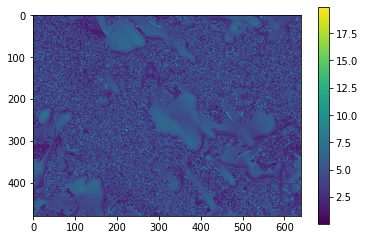

In [14]:
plt.imshow(plot_xs[2].log1p().cpu().numpy().transpose())
plt.colorbar()

In [15]:
fname = time.strftime("%Y%m%d-%H%M%S")
# out = cv2.VideoWriter(f'videos/CA-{fname}.avi',cv2.VideoWriter_fourcc(*'DIVX'), 60, (RESX, RESY), 3)
out = cv2.VideoWriter(f'videos/CA-{fname}.mp4',cv2.VideoWriter_fourcc(*'MP4V'), 240, (RESX, RESY), 3)


for img in imgs:
    # img = np.uint8(cv2.cvtColor(img, cv2.COLOR_RGB2BGR)*255.0)
    # img = np.uint8(cv2.cvtColor(img[..., 0], cv2.COLOR_RGB2BGR)).transpose(1, 0, 2)
    img = np.uint8(cv2.cvtColor(img, cv2.COLOR_RGB2BGR)).transpose(1, 0, 2)
    out.write(img)
out.release()

OpenCV: FFMPEG: tag 0x5634504d/'MP4V' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'


Text(0.5, 1.0, 'force')

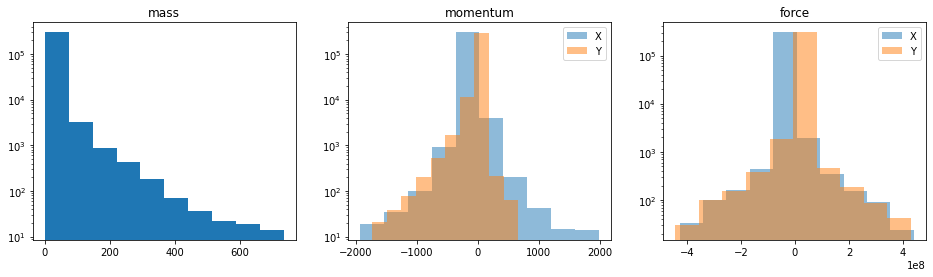

In [16]:
fig, axes = plt.subplots(1, 3, figsize=(16, 4))
axes[0].hist(mass.reshape(-1).cpu().detach().numpy());
axes[0].set_title('mass')
axes[0].set_yscale('log')

axes[1].hist(momentum[0].reshape(-1).cpu().detach().numpy(), alpha=0.5, label='X');
axes[1].hist(momentum[1].reshape(-1).cpu().detach().numpy(), alpha=0.5, label='Y');
axes[1].set_yscale('log')
axes[1].legend()

axes[1].set_title('momentum')

axes[2].hist(force[0].reshape(-1).cpu().detach().numpy(), alpha=0.5, label='X');
axes[2].hist(force[1].reshape(-1).cpu().detach().numpy(), alpha=0.5, label='Y');
axes[2].set_yscale('log')
axes[2].legend()
axes[2].set_title('force')